# Statistical & Financial Analysis

Purpose -> Richer descriptive analysis for slides and dashboard. Compares moving averages, technical indicators, portfolio stats, and CAPM relationships.

In [11]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import mplfinance as mpf

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
INGEST_DIR = Path("../ingestion/yfinance")
sys.path.append(str(INGEST_DIR))
import yfinance_methods_v2 as ym

# Dynamic subset and windows (edit or replace with widgets for dashboard)
TICKERS_SUBSET = ["AAPL","MSFT","QQQ","SPY"]
PLOT_TICKER = "AAPL"
MA_WINDOWS = [20, 50]

# Load data
ohlcv = pd.read_csv(DATA_DIR / "ohlcv.csv")
ohlcv["date"] = pd.to_datetime(ohlcv["date"], errors="coerce")
prices = ohlcv.pivot(index="date", columns="ticker", values="adj_close" if "adj_close" in ohlcv.columns else "close").sort_index()


## 1. Moving Averages (SMA/EMA)

Compare 4 tickers, plot price with SMA/EMA on a 2x2 grid.

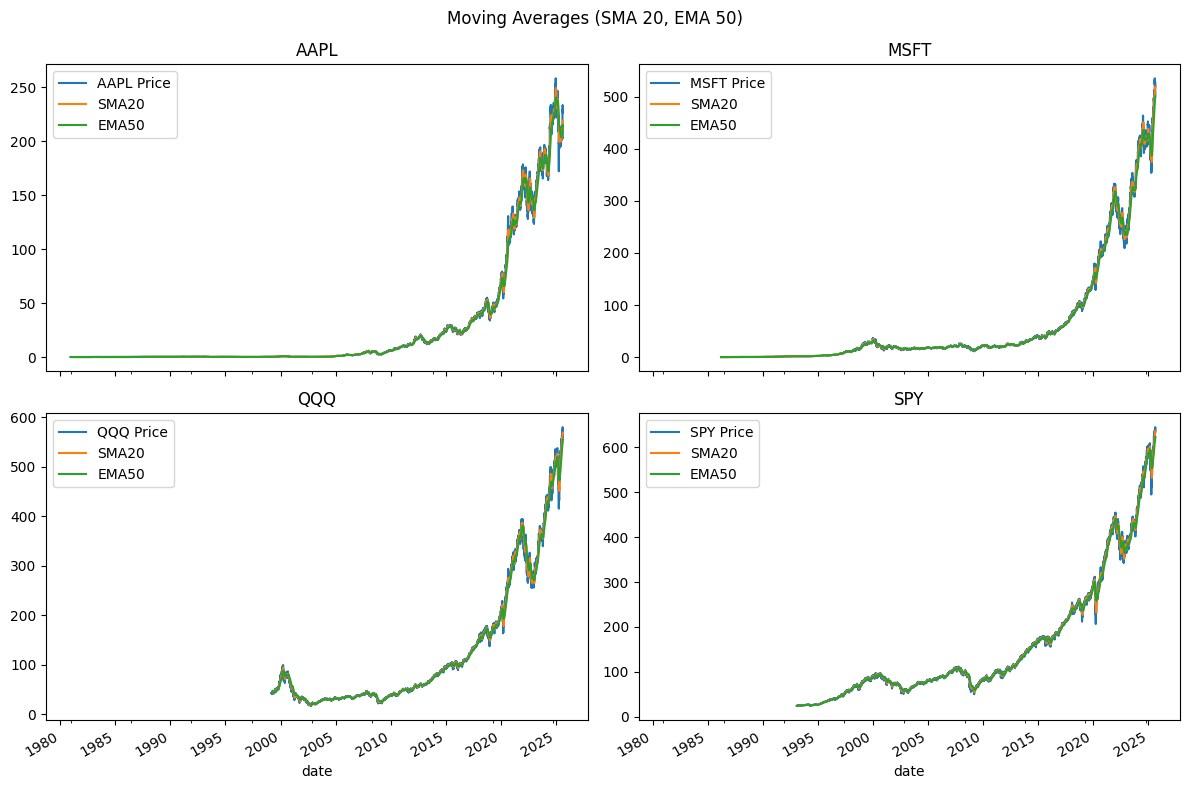

In [2]:
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True)
for i, tk in enumerate(TICKERS_SUBSET):
    s = prices[tk].dropna()
    sma = s.rolling(MA_WINDOWS[0]).mean()
    ema = s.ewm(span=MA_WINDOWS[1], adjust=False).mean()
    ax = axs[i//2, i%2]
    s.plot(ax=ax, label=f"{tk} Price")
    sma.plot(ax=ax, label=f"SMA{MA_WINDOWS[0]}")
    ema.plot(ax=ax, label=f"EMA{MA_WINDOWS[1]}")
    ax.set_title(tk)
    ax.legend()
plt.suptitle(f"Moving Averages (SMA {MA_WINDOWS[0]}, EMA {MA_WINDOWS[1]})")
plt.tight_layout()
plt.show()


## 2. Technical Indicators (RSI, Bollinger Bands, MACD)

Four indicator plots for one ticker (edit PLOT_TICKER).

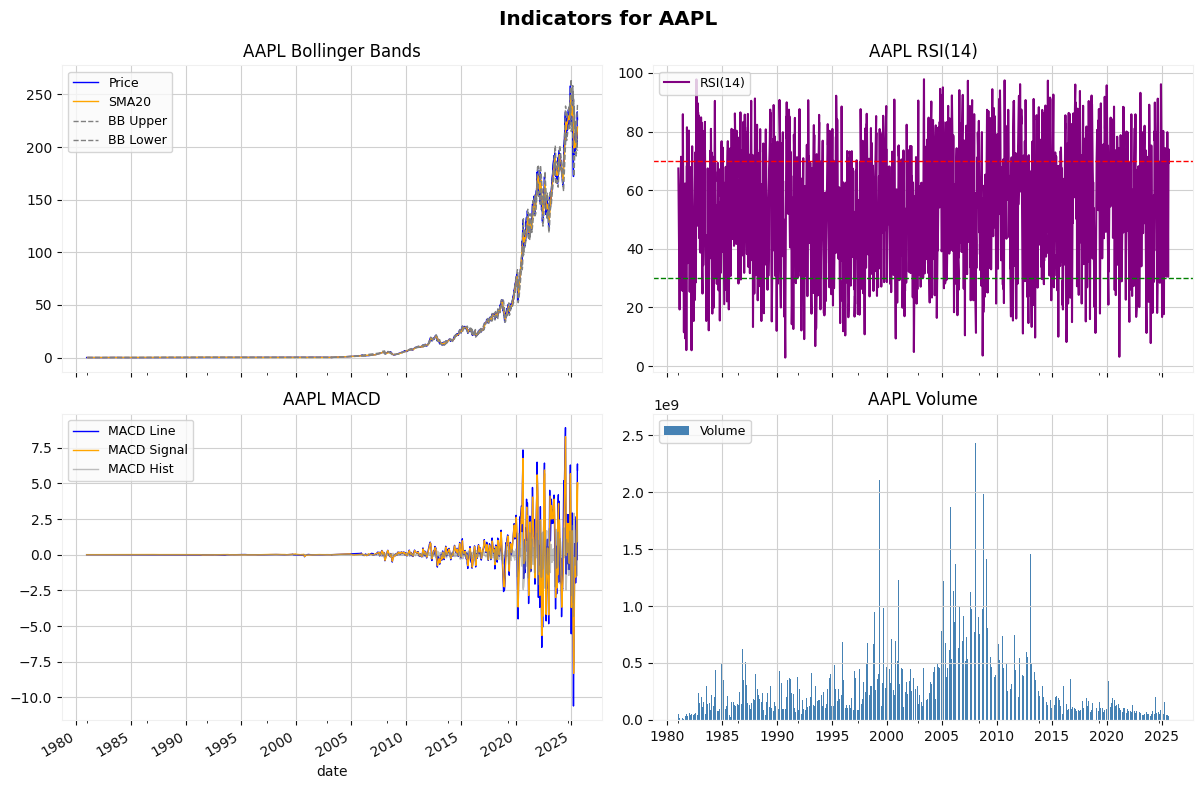

In [27]:
def RSI(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain, index=series.index).rolling(period).mean()
    avg_loss = pd.Series(loss, index=series.index).rolling(period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def MACD(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    macd_signal = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - macd_signal
    return macd_line, macd_signal, macd_hist

# -- Data prep (assume you already defined tk, s, sma, std, upper, lower, rsi, macd_line, macd_signal, macd_hist) --

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True)

# [0,0] Bollinger Bands
s.plot(ax=axs[0,0], label="Price", color="blue", linewidth=1)
sma.plot(ax=axs[0,0], label="SMA20", color="orange", linewidth=1)
upper.plot(ax=axs[0,0], color="gray", linestyle="--", label="BB Upper", linewidth=1)
lower.plot(ax=axs[0,0], color="gray", linestyle="--", label="BB Lower", linewidth=1)
axs[0,0].set_title(f"{tk} Bollinger Bands")
axs[0,0].legend(loc="upper left", fontsize=9)
axs[0,0].set_facecolor("white")

# [0,1] RSI
rsi.plot(ax=axs[0,1], color="purple", label="RSI(14)", linewidth=1.5)
axs[0,1].axhline(70, color="red", linestyle="--", linewidth=1)
axs[0,1].axhline(30, color="green", linestyle="--", linewidth=1)
axs[0,1].set_title(f"{tk} RSI(14)")
axs[0,1].legend(loc="upper left", fontsize=9)
axs[0,1].set_facecolor("white")

# [1,0] MACD
macd_line.plot(ax=axs[1,0], label="MACD Line", color="blue", linewidth=1)
macd_signal.plot(ax=axs[1,0], label="MACD Signal", color="orange", linewidth=1)
macd_hist.plot(ax=axs[1,0], label="MACD Hist", alpha=0.5, color="gray", linewidth=1)
axs[1,0].set_title(f"{tk} MACD")
axs[1,0].legend(loc="upper left", fontsize=9)
axs[1,0].set_facecolor("white")

# [1,1] Volume plot
vol_series = ohlcv.loc[ohlcv["ticker"] == tk].set_index("date")["volume"].sort_index()
axs[1,1].set_ylim(0, np.percentile(vol_series.values, 99.9))  # or tweak to 95th/98th percentile
axs[1,1].bar(vol_series.index, vol_series.values, width=1, color="steelblue", label="Volume")
axs[1,1].set_title(f"{tk} Volume")
axs[1,1].legend(loc="upper left", fontsize=9)
axs[1,1].set_facecolor("white")

plt.suptitle(f"Indicators for {tk}")
plt.tight_layout()
plt.show()


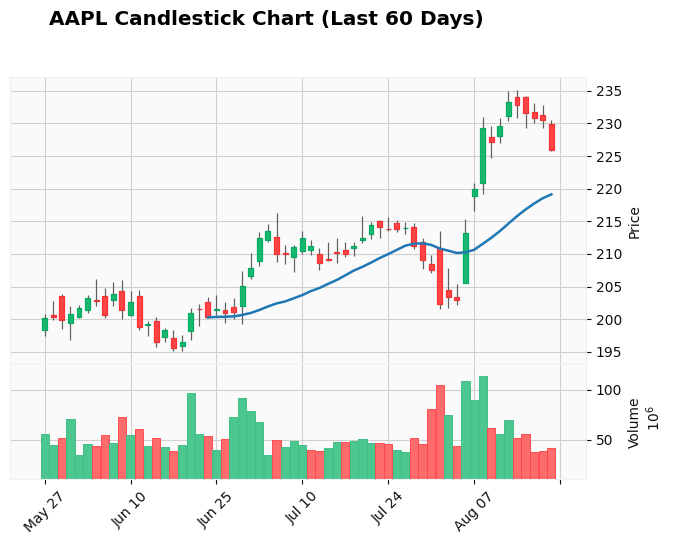

In [28]:
# Last 60 days of OHLCV for current ticker
candle_df = ohlcv[ohlcv["ticker"] == tk][["date", "open", "high", "low", "close", "volume"]].copy()
candle_df = candle_df.set_index("date").sort_index().tail(60)
candle_df.index = pd.to_datetime(candle_df.index)

# Plot (with volume and 20-day MA overlay)
mpf.plot(
    candle_df,
    type='candle',
    style='yahoo',
    mav=(20),
    volume=True,
    title=f"{tk} Candlestick Chart (Last 60 Days)",
    ylabel="Price",
    ylabel_lower="Volume",
    show_nontrading=False
)

## 3. Sharpe & Sortino Ratios

Compute risk-adjusted return ratios for subset.

In [4]:
returns = prices.pct_change().dropna()
rf = 0

def sharpe(series):
    mu = series.mean() * 252
    sigma = series.std() * np.sqrt(252)
    return (mu - rf) / sigma if sigma > 0 else np.nan

def sortino(series):
    neg_std = series[series < 0].std() * np.sqrt(252)
    mu = series.mean() * 252
    return (mu - rf) / neg_std if neg_std > 0 else np.nan

ratio_table = pd.DataFrame({
    "Sharpe": [sharpe(returns[tk]) for tk in TICKERS_SUBSET],
    "Sortino": [sortino(returns[tk]) for tk in TICKERS_SUBSET]
}, index=TICKERS_SUBSET)
display(ratio_table)


C:\Users\sherv\AppData\Local\Temp\ipykernel_2364\1850853378.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


,Sharpe,Sortino
AAPL,0.845879,1.159521
MSFT,1.019384,1.409449
QQQ,0.956148,1.220311
SPY,0.900200,1.099975


## 4. Drawdown Analysis

Drawdown plots for subset in 2x2 grid.

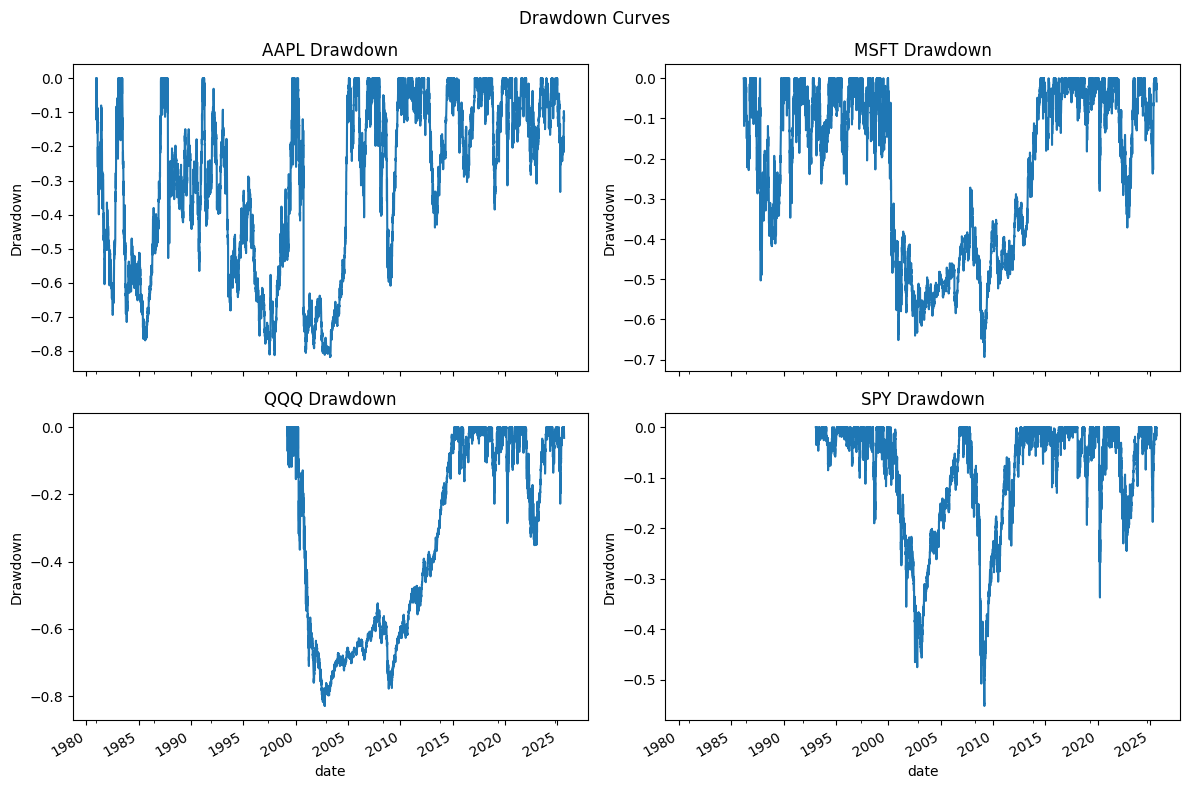

In [5]:
def drawdown(series):
    roll_max = series.cummax()
    dd = series / roll_max - 1
    return dd

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True)
for i, tk in enumerate(TICKERS_SUBSET):
    dd = drawdown(prices[tk].dropna())
    dd.plot(ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f"{tk} Drawdown")
    axs[i//2, i%2].set_ylabel("Drawdown")
plt.suptitle("Drawdown Curves")
plt.tight_layout()
plt.show()


## 5. Beta & Alpha (CAPM)

Compute beta and alpha vs SPY and show scatter fit for AAPL.

,Beta,Alpha
Ticker,,
AAPL,1.185060,0.000241
MSFT,1.175056,0.000349
QQQ,1.143887,0.000097


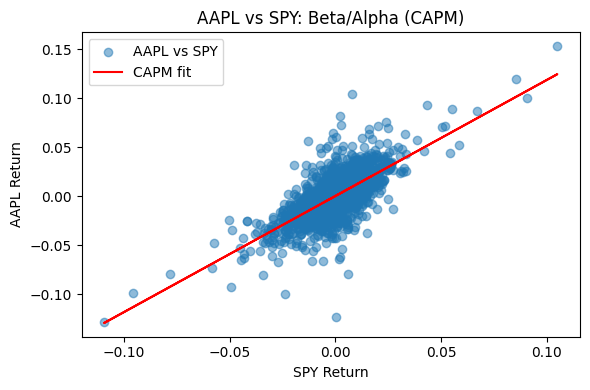

In [6]:
subset = TICKERS_SUBSET
results = []
for tk in subset:
    if tk == "SPY": continue
    y = returns[tk].dropna()
    x = returns["SPY"].reindex_like(y)
    X = sm.add_constant(x)
    capm = sm.OLS(y, X, missing="drop").fit()
    results.append({"Ticker": tk, "Beta": capm.params["SPY"], "Alpha": capm.params["const"]})

capm_df = pd.DataFrame(results).set_index("Ticker")
display(capm_df)

# Scatter for AAPL vs SPY
y = returns["AAPL"].dropna()
x = returns["SPY"].reindex_like(y)
plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.5, label="AAPL vs SPY")
beta, alpha = capm_df.loc["AAPL",["Beta","Alpha"]]
plt.plot(x, alpha + beta * x, color="red", label="CAPM fit")
plt.xlabel("SPY Return")
plt.ylabel("AAPL Return")
plt.legend()
plt.title("AAPL vs SPY: Beta/Alpha (CAPM)")
plt.tight_layout()
plt.show()


## 6. Portfolio Simulation (Equal vs Vol-Weighted)

Compare cumulative returns for equal-weight and volatility-weighted portfolios.

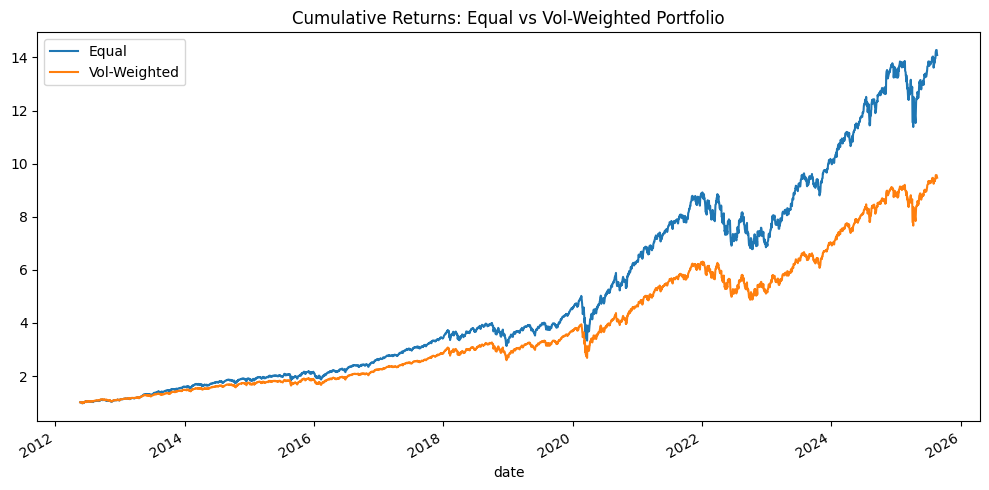

In [8]:
vol = returns.rolling(60).std().iloc[-1]
w_eq = np.repeat(1/returns.shape[1], returns.shape[1])
w_vw = (1/vol) / (1/vol).sum()
port_eq = (returns * w_eq).sum(axis=1)
port_vw = (returns * w_vw).sum(axis=1)
pd.DataFrame({"Equal": port_eq, "Vol-Weighted": port_vw}).add(1).cumprod().plot(figsize=(10,5))
plt.title("Cumulative Returns: Equal vs Vol-Weighted Portfolio")
plt.tight_layout()
plt.show()


# Finance Metrics & Plots Cheatsheet

## 1. Moving Averages

**Simple Moving Average (SMA):**
- The arithmetic mean of closing prices over the last _N_ periods.
- **Formula:**  
  `SMA_N = (P_t + P_{t-1} + ... + P_{t-N+1}) / N`
- **Use:** Smooths short-term price fluctuations, identifies trends.

**Exponential Moving Average (EMA):**
- Weighted average that gives more importance to recent prices.
- **Formula (recursively):**  
  `EMA_t = α * P_t + (1-α) * EMA_{t-1}`  
  where `α = 2 / (N+1)`
- **Use:** Responds faster to price changes than SMA.

---

## 2. Bollinger Bands

- Volatility envelope drawn above and below SMA (usually 20 days).
- **Upper Band:** SMA + 2 × rolling standard deviation  
- **Lower Band:** SMA - 2 × rolling standard deviation
- **Interpretation:**  
  Price touching upper/lower bands may indicate overbought/oversold conditions.

---

## 3. Relative Strength Index (RSI)

- **Momentum oscillator**: measures speed and change of price movements.
- **Scale:** 0–100; overbought >70, oversold <30.
- **Formula:**  
  `RSI = 100 - (100 / (1 + RS))`  
  Where `RS = average gain / average loss`
- **Use:** Detects potential reversal points.

---

## 4. MACD (Moving Average Convergence Divergence)

- **Trend-following momentum indicator**
- **MACD Line:** 12-day EMA minus 26-day EMA
- **Signal Line:** 9-day EMA of the MACD Line
- **Histogram:** MACD Line minus Signal Line
- **Use:** Signal crossovers (buy/sell), divergence from price.

---

## 5. Volume

- **Total shares/contracts traded in a given time period.**
- **Use:** High volume often confirms price moves or signals possible reversals.

---

## 6. Sharpe Ratio

- **Risk-adjusted return:**  
  `Sharpe = (E[R] - R_f) / σ`  
  Where `E[R]` is expected return, `R_f` is risk-free rate, `σ` is volatility.
- **Use:** Higher Sharpe means better risk-adjusted performance.

---

## 7. Sortino Ratio

- Like Sharpe, but penalizes only downside volatility (bad risk).
- `Sortino = (E[R] - R_f) / σ_D`  
  Where `σ_D` is std. dev. of negative returns only.

---

## 8. Drawdown

- **Drawdown:** Percentage drop from previous peak.
- `Drawdown_t = (P_t - Peak_t) / Peak_t`
- **Use:** Measures risk of large losses; max drawdown is key portfolio risk metric.

---

## 9. Beta & Alpha (CAPM)

- **Beta:** Measures sensitivity to market (e.g., SPY).  
  `Beta = Cov(R_stock, R_mkt) / Var(R_mkt)`
- **Alpha:** Excess return not explained by beta (i.e., skill).  
  `Alpha = E[R_stock] - R_f - Beta * (E[R_mkt] - R_f)`
- **Use:**  
  - Beta >1: more volatile than market  
  - Alpha >0: outperformance

---

## 10. Portfolio Simulation

- **Equal-weight portfolio:** Each asset weighted equally.
- **Volatility-weighted portfolio:** Lower-vol assets get higher weight.
- **Cumulative returns:**  
  `Cumulative Return_t = Product_{i=1}^t (1 + r_i)`
- **Use:** Compare portfolio strategies over time.

---

## 11. Candlestick Plot

- **Shows:** Open, high, low, close for each period as a "candle".
  - Green/up candle: close > open (body is hollow or green)
  - Red/down candle: close < open (body is filled or red)
- **Use:** Quickly visualizes price trends, gaps, and volatility.

---

## 12. RSI, MACD, Stochastic, Volume—How to Interpret

- **RSI:** High (>70) means overbought, low (<30) means oversold.
- **MACD:** Cross above signal line = bullish, below = bearish.
- **Stochastic:** Similar to RSI, but often generates more frequent signals.
- **Volume:** Spikes confirm price moves, divergences may warn of reversals.

---

